In [ ]:
import pandas as pd
import numpy as np
import folium
from pyproj import Transformer
import geopandas as gpd
from shapely.geometry import Point

# 데이터 불러오기
data = pd.read_csv('/Users/joomacbook/Desktop/경남 빅데이터 공모전/산청하동_XY좌표계_생활인구집계_행정동코드.csv')
# 1. 전체 경남 행정구역 경계 불러오기 (GeoDataFrame)
# 예시 파일 경로: '경남_행정경계.shp'
gdf_admin = gpd.read_file('/Users/joomacbook/Desktop/경남 빅데이터 공모전/LARD_ADM_SECT_SGG_경남/LARD_ADM_SECT_SGG_48_202505.shp')
# 좌표 변환 설정
transformer = Transformer.from_proj(
    "+proj=tmerc +lat_0=38 +lon_0=128 +k=0.9999 +x_0=400000 +y_0=600000 "
    "+ellps=bessel +units=m +no_defs +towgs84=-115.80,474.99,674.11,1.16,-2.31,-1.63,6.43",
    "EPSG:4326", always_xy=True
    )
data[['longitude', 'latitude']] = data[['X', 'Y']].apply(
    lambda row: transformer.transform(row['X'], row['Y']), axis=1, result_type="expand"
)

# 격자 크기 설정 (500m x 500m)
grid_width, grid_height = 500, 500

def create_grids_and_aggregate(data, grid_width, grid_height):
    x_min, x_max = data['X'].min(), data['X'].max()
    y_min, y_max = data['Y'].min(), data['Y'].max()
    
    x_bins = np.arange(x_min, x_max + grid_width, grid_width)
    y_bins = np.arange(y_min, y_max + grid_height, grid_height)
    
    grid_data = []
    
    for i in range(len(x_bins) - 1):
        for j in range(len(y_bins) - 1):
            x_start, x_end = x_bins[i], x_bins[i + 1]
            y_start, y_end = y_bins[j], y_bins[j + 1]

            cell_data = data[
                (data['X'] >= x_start) & (data['X'] < x_end) &
                (data['Y'] >= y_start) & (data['Y'] < y_end)
            ]
            집계값 = cell_data['집계값'].sum()
            center_x, center_y = (x_start + x_end) / 2, (y_start + y_end) / 2
            center_lon, center_lat = transformer.transform(center_x, center_y)

            grid_data.append({
                'x_start': x_start, 'x_end': x_end,
                'y_start': y_start, 'y_end': y_end,
                '집계값': 집계값,
                'center_lat': center_lat, 'center_lon': center_lon
            })
    
    grid_df = pd.DataFrame(grid_data)
    grid_df = grid_df[grid_df['집계값'] > 0]  # 0이 아닌 셀만 남김
    grid_df = grid_df.sort_values(by='집계값', ascending=False)
    
    quantiles = np.array_split(grid_df.index, 5)
    
    def get_color(index):
        if index in quantiles[0]:
            return '#000080'
        elif index in quantiles[1]:
            return '#4169E1'
        elif index in quantiles[2]:
            return '#1E90FF'
        elif index in quantiles[3]:
            return '#87CEEB'
        else:
            return '#E0FFFF'
    
    grid_df['color'] = grid_df.index.map(get_color)
    
    return grid_df

grid_data = create_grids_and_aggregate(data, grid_width, grid_height)

# 집계값 5 미만인 행 삭제 처리 
grid_data = grid_data[grid_data['집계값'] >= 5].copy()

def create_map(grid_data, output_file):
    m = folium.Map(location=[grid_data['center_lat'].mean(), grid_data['center_lon'].mean()], zoom_start=12)
    lat_ratio, lon_ratio = 0.00455, 0.00555
    
    for _, row in grid_data.iterrows():
        bounds = [
            [row['center_lat'] - (lat_ratio / 2), row['center_lon'] - (lon_ratio / 2)],
            [row['center_lat'] - (lat_ratio / 2), row['center_lon'] + (lon_ratio / 2)],
            [row['center_lat'] + (lat_ratio / 2), row['center_lon'] + (lon_ratio / 2)],
            [row['center_lat'] + (lat_ratio / 2), row['center_lon'] - (lon_ratio / 2)],
            [row['center_lat'] - (lat_ratio / 2), row['center_lon'] - (lon_ratio / 2)]
        ]
        folium.Polygon(
            locations=bounds,
            color=None, fill=True,
            fill_color=row['color'],
            fill_opacity=1.0
        ).add_to(m)
    
    m.save(output_file)

output_file = r"/Users/joomacbook/Desktop/경남 빅데이터 공모전/map_with_grid.html"
create_map(grid_data, output_file)
print(f"작업 완료! HTML 파일 생성됨: {output_file}")

gdf = pd.read_csv('/Users/joomacbook/Desktop/경남 빅데이터 공모전/산청+하동_5년간산불발생좌표.csv')
gdf.drop('field1', axis=1, inplace=True)
new_columns = [
    'damagearea', 'endday', 'endmonth', 'endtime', 'endyear', 'firecause',
    'locbunji', 'locdong', 'locgungu', 'locsi', 'startday', 'startdayofweek',
    'startmonth', 'starttime', 'startyear', 'locmenu', 'full_location'
]
gdf.columns = new_columns + ['GC_TYPE', 'CLEANADDR', 'X', 'Y']

# 좌표 → Point 형식으로 변환
geometry = [Point(xy) for xy in zip(gdf['X'], gdf['Y'])]

# GeoDataFrame 생성 (위경도 좌표계: EPSG:4326)
fire_gdf = gpd.GeoDataFrame(gdf, geometry=geometry, crs='EPSG:4326')

# 3. 버퍼 생성을 위해 meter 좌표계로 변환
fire_gdf_meter = fire_gdf.to_crs(epsg=5181)  # Korea TM

# 4. 1km, 3km, 5km 버퍼 생성
buffer_1km = fire_gdf_meter.buffer(1000).to_crs(epsg=4326)
buffer_2km = fire_gdf_meter.buffer(2000).to_crs(epsg=4326)
buffer_3km = fire_gdf_meter.buffer(3000).to_crs(epsg=4326)

gdf_admin = gpd.read_file('/Users/joomacbook/Desktop/경남 빅데이터 공모전/LARD_ADM_SECT_SGG_경남/LARD_ADM_SECT_SGG_48_202505.shp')
# 1. 지도 객체 생성 (격자 중심 기준)
m = folium.Map(location=[grid_data['center_lat'].mean(), grid_data['center_lon'].mean()], zoom_start=12)

# 2. 격자 히트맵 시각화
lat_ratio, lon_ratio = 0.00455, 0.00555

for _, row in grid_data.iterrows():
    bounds = [
        [row['center_lat'] - (lat_ratio / 2), row['center_lon'] - (lon_ratio / 2)],
        [row['center_lat'] - (lat_ratio / 2), row['center_lon'] + (lon_ratio / 2)],
        [row['center_lat'] + (lat_ratio / 2), row['center_lon'] + (lon_ratio / 2)],
        [row['center_lat'] + (lat_ratio / 2), row['center_lon'] - (lon_ratio / 2)],
        [row['center_lat'] - (lat_ratio / 2), row['center_lon'] - (lon_ratio / 2)]
    ]
    folium.Polygon(
        locations=bounds,
        color=None, fill=True,
        fill_color=row['color'],
        fill_opacity=1.0
    ).add_to(m)

# 3. 행정경계선 추가 (산청군·하동군)
gdf_boundary = gdf_admin[gdf_admin['SGG_NM'].str.contains('하동군|산청군')].to_crs(epsg=4326)

folium.GeoJson(
    gdf_boundary,
    style_function=lambda x: {
        'color': 'green',
        'weight': 3,
        'fillOpacity': 0,
        'dashArray': '5, 5'
    },
    name='행정경계선'
).add_to(m)

# 5. 버퍼 시각화
folium.GeoJson(
    buffer_1km,
    style_function=lambda x: {
        'fillColor': 'yellow',
        'color': 'yellow',
        'weight': 1,
        'fillOpacity': 0.2
    },
    name='버퍼 1km'
).add_to(m)

folium.GeoJson(
    buffer_2km,
    style_function=lambda x: {
        'fillColor': 'orange',
        'color': 'orange',
        'weight': 1,
        'fillOpacity': 0.2
    },
    name='버퍼 2km'
).add_to(m)

folium.GeoJson(
    buffer_3km,
    style_function=lambda x: {
        'fillColor': 'red',
        'color': 'red',
        'weight': 1,
        'fillOpacity': 0.2
    },
    name='버퍼 3km'
).add_to(m)

# 4. Layer Control 추가
folium.LayerControl().add_to(m)

# 5. 저장
m.save("map_with_grid_and_boundary.html")
print("저장 완료: map_with_grid_and_boundary.html")

작업 완료! HTML 파일 생성됨: /Users/joomacbook/Desktop/경남 빅데이터 공모전/map_with_grid.html
저장 완료: map_with_grid_and_boundary.html


In [90]:
grid_data

,x_start,x_end,y_start,y_end,집계값,center_lat,center_lon,color
7830,388802.0,389302.0,312943.0,313443.0,1809.710541,35.417959,127.877274,#000080
4464,377302.0,377802.0,274443.0,274943.0,1439.446645,35.070717,127.751695,#000080
7829,388802.0,389302.0,312443.0,312943.0,1396.075716,35.413452,127.877281,#000080
4321,376802.0,377302.0,274443.0,274943.0,1145.643148,35.070706,127.746213,#000080
4320,376802.0,377302.0,273943.0,274443.0,851.952366,35.066198,127.746226,#000080
...,...,...,...,...,...,...,...,...
4190,376302.0,376802.0,280443.0,280943.0,5.061667,35.124781,127.740560,#87CEEB
7593,388302.0,388802.0,265943.0,266443.0,5.059209,34.994278,127.872425,#87CEEB
928,364802.0,365302.0,293943.0,294443.0,5.040776,35.246138,127.613811,#87CEEB
9379,394302.0,394802.0,300943.0,301443.0,5.016173,35.309835,127.937919,#87CEEB


In [93]:
from shapely.geometry import Point
from math import sqrt

# 1. 격자 중심점 → GeoDataFrame
grid_gdf = gpd.GeoDataFrame(
    grid_data,
    geometry=[Point(xy) for xy in zip(grid_data['center_lon'], grid_data['center_lat'])],
    crs="EPSG:4326"
)

# 2. 격자 EPSG:5181로 변환 (버퍼 판별용)
grid_gdf_5181 = grid_gdf.to_crs(epsg=5181)

# 3. 산불 좌표 → EPSG:5181 (이미 fire_gdf_meter에 있음)
# 각 fire point 별로 buffer 1/2/3km → (Point, buffer1, buffer2, buffer3)
fire_buffers = []
for i, fire_point in fire_gdf_meter.iterrows():
    fire_buffers.append({
        'point_id': i,
        'buffer1': fire_point.geometry.buffer(1000),
        'buffer2': fire_point.geometry.buffer(2000),
        'buffer3': fire_point.geometry.buffer(3000)
    })

# 4. 격자별 스코어 계산
scores = []
for idx, grid in grid_gdf_5181.iterrows():
    total_score = 0
    included_fire_points = 0
    
    for fire in fire_buffers:
        pt = grid.geometry
        
        if fire['buffer1'].contains(pt):
            total_score += 3
            included_fire_points += 1
        elif fire['buffer2'].contains(pt):
            total_score += 2
            included_fire_points += 1
        elif fire['buffer3'].contains(pt):
            total_score += 1
            included_fire_points += 1
    
    if included_fire_points > 0:
        score = total_score / sqrt(included_fire_points)
    else:
        score = 0
    
    scores.append(score)

# 5. 점수 업데이트
grid_gdf['score'] = scores

In [94]:
grid_gdf

,x_start,x_end,y_start,y_end,집계값,center_lat,center_lon,color,geometry,score
7830,388802.0,389302.0,312943.0,313443.0,1809.710541,35.417959,127.877274,#000080,POINT (127.87727 35.41796),0.0
4464,377302.0,377802.0,274443.0,274943.0,1439.446645,35.070717,127.751695,#000080,POINT (127.75169 35.07072),3.0
7829,388802.0,389302.0,312443.0,312943.0,1396.075716,35.413452,127.877281,#000080,POINT (127.87728 35.41345),0.0
4321,376802.0,377302.0,274443.0,274943.0,1145.643148,35.070706,127.746213,#000080,POINT (127.74621 35.07071),2.0
4320,376802.0,377302.0,273943.0,274443.0,851.952366,35.066198,127.746226,#000080,POINT (127.74623 35.0662),2.0
...,...,...,...,...,...,...,...,...,...,...
4190,376302.0,376802.0,280443.0,280943.0,5.061667,35.124781,127.740560,#87CEEB,POINT (127.74056 35.12478),0.0
7593,388302.0,388802.0,265943.0,266443.0,5.059209,34.994278,127.872425,#87CEEB,POINT (127.87242 34.99428),2.0
928,364802.0,365302.0,293943.0,294443.0,5.040776,35.246138,127.613811,#87CEEB,POINT (127.61381 35.24614),0.0
9379,394302.0,394802.0,300943.0,301443.0,5.016173,35.309835,127.937919,#87CEEB,POINT (127.93792 35.30983),0.0


In [95]:
grid_gdf['score'].unique()

array([0.        , 3.        , 2.        , 2.82842712, 1.        ,
       1.41421356, 2.12132034, 3.53553391, 1.73205081, 2.30940108])

In [19]:
# 색상 분류: 5등분
grid_gdf['score_rank'] = pd.qcut(grid_gdf['score'], 5, labels=False, duplicates='drop')

def get_score_color(rank):
    if np.isnan(rank):
        return '#FFFFFF'  # 점수 없음 (하얀색)
    # 진한 빨강 계열: 낮은 점수 → 옅은 붉은색, 높은 점수 → 매우 진한 빨강
    red_gradient = ['#FFCCCC', '#FF6666', '#FF0000', '#CC0000', '#660000']
    return red_gradient[int(rank)]

grid_gdf['color'] = grid_gdf['score_rank'].apply(get_score_color)


In [20]:
# 새 folium 지도 객체
m = folium.Map(location=[grid_gdf['center_lat'].mean(), grid_gdf['center_lon'].mean()], zoom_start=12)

for _, row in grid_gdf.iterrows():
    bounds = [
        [row['center_lat'] - (lat_ratio / 2), row['center_lon'] - (lon_ratio / 2)],
        [row['center_lat'] - (lat_ratio / 2), row['center_lon'] + (lon_ratio / 2)],
        [row['center_lat'] + (lat_ratio / 2), row['center_lon'] + (lon_ratio / 2)],
        [row['center_lat'] + (lat_ratio / 2), row['center_lon'] - (lon_ratio / 2)],
        [row['center_lat'] - (lat_ratio / 2), row['center_lon'] - (lon_ratio / 2)]
    ]
    folium.Polygon(
        locations=bounds,
        color=None,
        fill=True,
        fill_color=row['color'],
        fill_opacity=1.0
    ).add_to(m)

# 행정경계선 추가
folium.GeoJson(
    gdf_boundary,
    style_function=lambda x: {
        'color': 'green',
        'weight': 3,
        'fillOpacity': 0,
        'dashArray': '5, 5'
    },
    name='행정경계선'
).add_to(m)

# 버퍼 추가 (옵션)
folium.GeoJson(buffer_1km, style_function=lambda x: {'fillColor': 'red', 'color': 'red', 'weight': 1, 'fillOpacity': 0.2}, name='버퍼 1km').add_to(m)
folium.GeoJson(buffer_2km, style_function=lambda x: {'fillColor': 'orange', 'color': 'orange', 'weight': 1, 'fillOpacity': 0.2}, name='버퍼 2km').add_to(m)
folium.GeoJson(buffer_3km, style_function=lambda x: {'fillColor': 'yellow', 'color': 'yellow', 'weight': 1, 'fillOpacity': 0.2}, name='버퍼 3km').add_to(m)

folium.LayerControl().add_to(m)
m.save("map_with_scored_grid.html")
print("저장 완료: map_with_scored_grid.html")


저장 완료: map_with_scored_grid.html


In [21]:
grid_gdf

,x_start,x_end,y_start,y_end,집계값,center_lat,center_lon,color,geometry,score,score_rank
7830,388802.0,389302.0,312943.0,313443.0,1809.710541,35.417959,127.877274,#FFCCCC,POINT (127.87727 35.41796),0.00000,0
4464,377302.0,377802.0,274443.0,274943.0,1439.446645,35.070717,127.751695,#FF0000,POINT (127.75169 35.07072),3.00000,2
7829,388802.0,389302.0,312443.0,312943.0,1396.075716,35.413452,127.877281,#FFCCCC,POINT (127.87728 35.41345),0.00000,0
4321,376802.0,377302.0,274443.0,274943.0,1145.643148,35.070706,127.746213,#FF6666,POINT (127.74621 35.07071),2.00000,1
4320,376802.0,377302.0,273943.0,274443.0,851.952366,35.066198,127.746226,#FF6666,POINT (127.74623 35.0662),2.00000,1
...,...,...,...,...,...,...,...,...,...,...,...
7332,387302.0,387802.0,278443.0,278943.0,1.000000,35.106949,127.861282,#FFCCCC,POINT (127.86128 35.10695),1.00000,0
5740,381802.0,382302.0,268943.0,269443.0,1.000000,35.021227,127.801155,#FFCCCC,POINT (127.80116 35.02123),0.00000,0
7790,388802.0,389302.0,292943.0,293443.0,1.000000,35.237675,127.877543,#FFCCCC,POINT (127.87754 35.23768),0.00000,0
11687,402302.0,402802.0,310943.0,311443.0,1.000000,35.399988,128.025925,#FF0000,POINT (128.02593 35.39999),2.12132,2


In [32]:
grid_gdf['score'].sort_values(ascending=False).value_counts()

score
0.000000    1013
1.000000     336
2.000000     249
2.121320     105
3.000000      74
1.414214      72
2.828427      60
3.535534      22
2.309401       4
1.732051       2
4.618802       1
Name: count, dtype: int64

/var/folders/wn/fg3vjbj159x6j8g18tzqxpwm0000gn/T/ipykernel_19099/250050642.py:11: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/wn/fg3vjbj159x6j8g18tzqxpwm0000gn/T/ipykernel_19099/250050642.py:11: UserWarning: Glyph 54252 (\N{HANGUL SYLLABLE PO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/wn/fg3vjbj159x6j8g18tzqxpwm0000gn/T/ipykernel_19099/250050642.py:11: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/wn/fg3vjbj159x6j8g18tzqxpwm0000gn/T/ipykernel_19099/250050642.py:11: UserWarning: Glyph 44033 (\N{HANGUL SYLLABLE GAG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/wn/fg3vjbj159x6j8g18tzqxpwm0000gn/T/ipykernel_19099/250050642.py:11: UserWarning: Glyph 54868 (\N{HANGUL SYLLABLE HWA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/joomacbook/anaconda3/envs/sprinter/lib/python3.12/site-

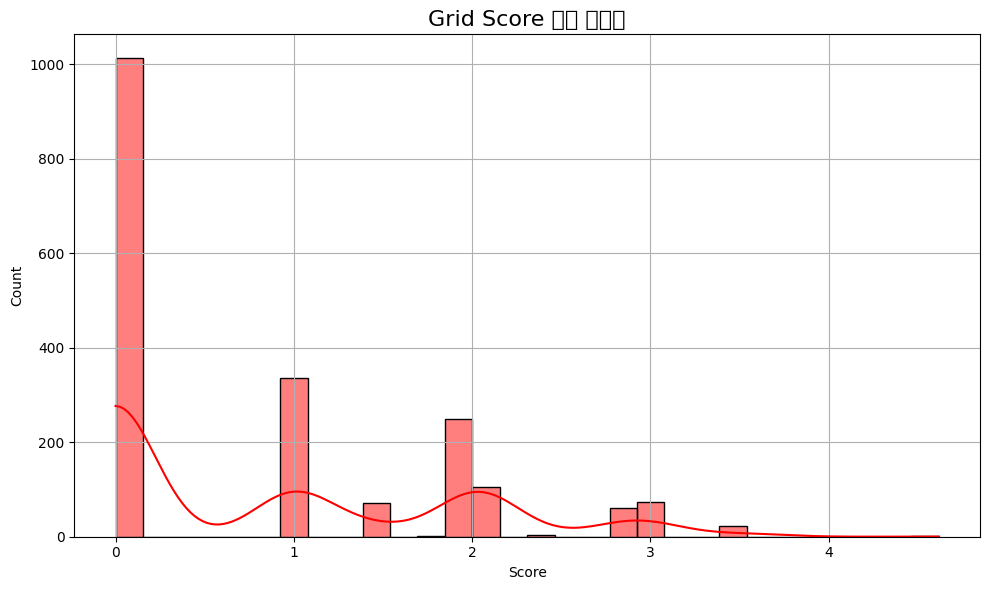

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(grid_gdf['score'], bins=30, kde=True, color='red', edgecolor='black')

plt.title('Grid Score 분포 시각화', fontsize=16)
plt.xlabel('Score')
plt.ylabel('Count')
plt.grid(True)
plt.tight_layout()
plt.show()


## gpt가 임의로 랭크매긴거

In [35]:
grid_gdf['score_rank'].value_counts()

score_rank
0    1349
1     323
2     266
Name: count, dtype: int64

In [ ]:
grid_gdf['score_rank'].value_counts()

score_rank
0    0.696078
1    0.166667
2    0.137255
Name: proportion, dtype: float64

In [38]:
grid_gdf.groupby('score_rank')['score'].value_counts().sort_index()


score_rank  score   
0           0.000000    1013
            1.000000     336
1           1.414214      72
            1.732051       2
            2.000000     249
2           2.121320     105
            2.309401       4
            2.828427      60
            3.000000      74
            3.535534      22
            4.618802       1
Name: count, dtype: int64

## 젠크스

In [40]:
pip install mapclassify

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 6.6 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [51]:
from mapclassify import NaturalBreaks

# Jenks Natural Breaks로 4개 구간으로 나누기
nb = NaturalBreaks(grid_gdf['score'], k=4)

# 구간 라벨 (0~3)을 score_rank로 저장
grid_gdf['score_rank2'] = nb.yb

grid_gdf.groupby('score_rank2')['score'].value_counts().sort_index()


score_rank2  score   
0            0.000000    1013
1            1.000000     336
             1.414214      72
2            1.732051       2
             2.000000     249
             2.121320     105
             2.309401       4
3            2.828427      60
             3.000000      74
             3.535534      22
             4.618802       1
Name: count, dtype: int64

In [44]:
grid_gdf['score_rank2'].value_counts()

score_rank2
0    1013
1     408
2     360
3     157
Name: count, dtype: int64

## Elbow Method

In [46]:
pip install jenkspy

Note: you may need to restart the kernel to use updated packages.


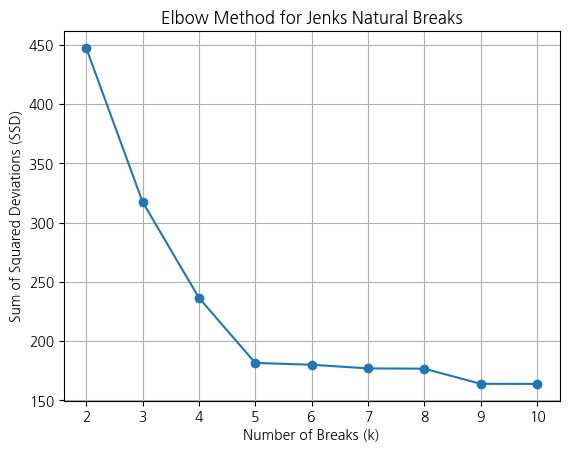

In [96]:
import jenkspy
import numpy as np
import matplotlib.pyplot as plt

scores = grid_gdf['score'].values
scores = scores[~np.isnan(scores)]  # NaN 제거

k_values = range(2, 11)
ssds = []

for k in k_values:
    breaks = jenkspy.jenks_breaks(scores, n_classes=k)
    ssd = sum(
        (x - np.mean([b for b in scores if b >= breaks[i] and b <= breaks[i+1]])) ** 2
        for i in range(len(breaks) - 1)
        for x in scores if x >= breaks[i] and x <= breaks[i+1]
    )
    ssds.append(ssd)

# Elbow plot 시각화
plt.plot(k_values, ssds, marker='o')
plt.xlabel('Number of Breaks (k)')
plt.ylabel('Sum of Squared Deviations (SSD)')
plt.title('Elbow Method for Jenks Natural Breaks')
plt.grid(True)
plt.show()


In [97]:
from mapclassify import NaturalBreaks

# Jenks Natural Breaks로 5개 구간으로 나누기
nb = NaturalBreaks(grid_gdf['score'], k=5)

# 구간 라벨 (0~3)을 score_rank로 저장
grid_gdf['score_rank5'] = nb.yb

grid_gdf.groupby('score_rank5')['score'].value_counts().sort_index()


score_rank5  score   
0            0.000000    590
1            1.000000    205
2            1.414214     49
3            1.732051      1
             2.000000    164
             2.121320     77
             2.309401      2
4            2.828427     36
             3.000000     45
             3.535534     13
Name: count, dtype: int64

In [98]:
grid_gdf['score_rank5'].value_counts()

score_rank5
0    590
3    244
1    205
4     94
2     49
Name: count, dtype: int64

- k=4일 때와 k=5일때의 랭크 0과 4(3)는 동일
- 중간인 1, 2에서 클러스터가 바뀜

In [55]:
grid_gdf

,x_start,x_end,y_start,y_end,집계값,center_lat,center_lon,color,geometry,score,score_rank,score_rank2,score_rank5
7830,388802.0,389302.0,312943.0,313443.0,1809.710541,35.417959,127.877274,#FFCCCC,POINT (127.87727 35.41796),0.00000,0,0,0
4464,377302.0,377802.0,274443.0,274943.0,1439.446645,35.070717,127.751695,#FF0000,POINT (127.75169 35.07072),3.00000,2,3,4
7829,388802.0,389302.0,312443.0,312943.0,1396.075716,35.413452,127.877281,#FFCCCC,POINT (127.87728 35.41345),0.00000,0,0,0
4321,376802.0,377302.0,274443.0,274943.0,1145.643148,35.070706,127.746213,#FF6666,POINT (127.74621 35.07071),2.00000,1,2,3
4320,376802.0,377302.0,273943.0,274443.0,851.952366,35.066198,127.746226,#FF6666,POINT (127.74623 35.0662),2.00000,1,2,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7332,387302.0,387802.0,278443.0,278943.0,1.000000,35.106949,127.861282,#FFCCCC,POINT (127.86128 35.10695),1.00000,0,1,1
5740,381802.0,382302.0,268943.0,269443.0,1.000000,35.021227,127.801155,#FFCCCC,POINT (127.80116 35.02123),0.00000,0,0,0
7790,388802.0,389302.0,292943.0,293443.0,1.000000,35.237675,127.877543,#FFCCCC,POINT (127.87754 35.23768),0.00000,0,0,0
11687,402302.0,402802.0,310943.0,311443.0,1.000000,35.399988,128.025925,#FF0000,POINT (128.02593 35.39999),2.12132,2,2,3


In [57]:
grid_gdf.isna().sum()

x_start        0
x_end          0
y_start        0
y_end          0
집계값            0
center_lat     0
center_lon     0
color          0
geometry       0
score          0
score_rank     0
score_rank2    0
score_rank5    0
dtype: int64

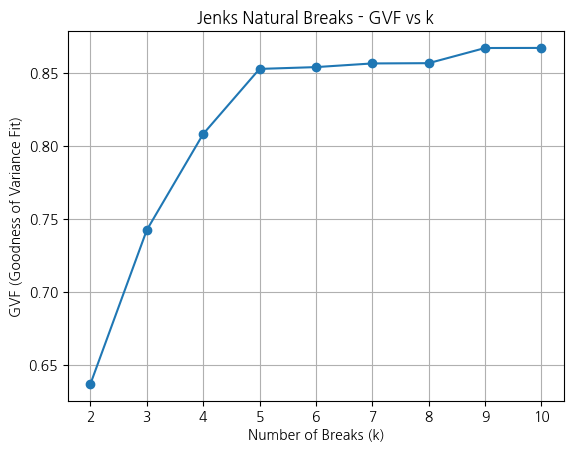

In [99]:
sdam = sum((x - np.mean(scores)) ** 2 for x in scores)  # 전체 분산

gvfs = []

for k in k_values:
    breaks = jenkspy.jenks_breaks(scores, n_classes=k)
    ssd = sum(
        (x - np.mean([b for b in scores if b >= breaks[i] and b <= breaks[i+1]])) ** 2
        for i in range(len(breaks) - 1)
        for x in scores if x >= breaks[i] and x <= breaks[i+1]
    )
    gvf = (sdam - ssd) / sdam
    gvfs.append(gvf)

# GVF 그래프 시각화
plt.plot(k_values, gvfs, marker='o')
plt.xlabel('Number of Breaks (k)')
plt.ylabel('GVF (Goodness of Variance Fit)')
plt.title('Jenks Natural Breaks - GVF vs k')
plt.grid(True)
plt.show()


In [59]:
grid_gdf

,x_start,x_end,y_start,y_end,집계값,center_lat,center_lon,color,geometry,score,score_rank,score_rank2,score_rank5
7830,388802.0,389302.0,312943.0,313443.0,1809.710541,35.417959,127.877274,#FFCCCC,POINT (127.87727 35.41796),0.00000,0,0,0
4464,377302.0,377802.0,274443.0,274943.0,1439.446645,35.070717,127.751695,#FF0000,POINT (127.75169 35.07072),3.00000,2,3,4
7829,388802.0,389302.0,312443.0,312943.0,1396.075716,35.413452,127.877281,#FFCCCC,POINT (127.87728 35.41345),0.00000,0,0,0
4321,376802.0,377302.0,274443.0,274943.0,1145.643148,35.070706,127.746213,#FF6666,POINT (127.74621 35.07071),2.00000,1,2,3
4320,376802.0,377302.0,273943.0,274443.0,851.952366,35.066198,127.746226,#FF6666,POINT (127.74623 35.0662),2.00000,1,2,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7332,387302.0,387802.0,278443.0,278943.0,1.000000,35.106949,127.861282,#FFCCCC,POINT (127.86128 35.10695),1.00000,0,1,1
5740,381802.0,382302.0,268943.0,269443.0,1.000000,35.021227,127.801155,#FFCCCC,POINT (127.80116 35.02123),0.00000,0,0,0
7790,388802.0,389302.0,292943.0,293443.0,1.000000,35.237675,127.877543,#FFCCCC,POINT (127.87754 35.23768),0.00000,0,0,0
11687,402302.0,402802.0,310943.0,311443.0,1.000000,35.399988,128.025925,#FF0000,POINT (128.02593 35.39999),2.12132,2,2,3


In [107]:
buffer_grid_score = grid_gdf[['x_start', 'x_end', 'y_start', 'y_end', 'center_lat', 'center_lon', 'geometry', 'score', 'score_rank5']]
buffer_grid_score

,x_start,x_end,y_start,y_end,center_lat,center_lon,geometry,score,score_rank5
7830,388802.0,389302.0,312943.0,313443.0,35.417959,127.877274,POINT (127.87727 35.41796),0.0,0
4464,377302.0,377802.0,274443.0,274943.0,35.070717,127.751695,POINT (127.75169 35.07072),3.0,4
7829,388802.0,389302.0,312443.0,312943.0,35.413452,127.877281,POINT (127.87728 35.41345),0.0,0
4321,376802.0,377302.0,274443.0,274943.0,35.070706,127.746213,POINT (127.74621 35.07071),2.0,3
4320,376802.0,377302.0,273943.0,274443.0,35.066198,127.746226,POINT (127.74623 35.0662),2.0,3
...,...,...,...,...,...,...,...,...,...
4190,376302.0,376802.0,280443.0,280943.0,35.124781,127.740560,POINT (127.74056 35.12478),0.0,0
7593,388302.0,388802.0,265943.0,266443.0,34.994278,127.872425,POINT (127.87242 34.99428),2.0,3
928,364802.0,365302.0,293943.0,294443.0,35.246138,127.613811,POINT (127.61381 35.24614),0.0,0
9379,394302.0,394802.0,300943.0,301443.0,35.309835,127.937919,POINT (127.93792 35.30983),0.0,0


In [108]:
buffer_grid_score.to_csv('산불발생버퍼에따른좌표별스코어링.csv')

In [101]:

def get_score_color(rank):
    if np.isnan(rank):
        return '#FFFFFF'  # 점수 없음 (하얀색)
    # 진한 빨강 계열: 낮은 점수 → 옅은 붉은색, 높은 점수 → 매우 진한 빨강
    red_gradient = ['#FFCCCC', '#FF6666', '#FF0000', '#CC0000', '#660000']
    return red_gradient[int(rank)]

grid_gdf['color'] = grid_gdf['score_rank5'].apply(get_score_color)

# 새 folium 지도 객체
m = folium.Map(location=[grid_gdf['center_lat'].mean(), grid_gdf['center_lon'].mean()], zoom_start=12)

for _, row in grid_gdf.iterrows():
    bounds = [
        [row['center_lat'] - (lat_ratio / 2), row['center_lon'] - (lon_ratio / 2)],
        [row['center_lat'] - (lat_ratio / 2), row['center_lon'] + (lon_ratio / 2)],
        [row['center_lat'] + (lat_ratio / 2), row['center_lon'] + (lon_ratio / 2)],
        [row['center_lat'] + (lat_ratio / 2), row['center_lon'] - (lon_ratio / 2)],
        [row['center_lat'] - (lat_ratio / 2), row['center_lon'] - (lon_ratio / 2)]
    ]
    folium.Polygon(
        locations=bounds,
        color=None,
        fill=True,
        fill_color=row['color'],
        fill_opacity=1.0
    ).add_to(m)

# 행정경계선 추가
folium.GeoJson(
    gdf_boundary,
    style_function=lambda x: {
        'color': 'green',
        'weight': 3,
        'fillOpacity': 0,
        'dashArray': '5, 5'
    },
    name='행정경계선'
).add_to(m)

# 버퍼 추가 (옵션)
folium.GeoJson(buffer_1km, style_function=lambda x: {'fillColor': 'yellow', 'color': 'yellow', 'weight': 1, 'fillOpacity': 0.2}, name='버퍼 1km').add_to(m)
folium.GeoJson(buffer_2km, style_function=lambda x: {'fillColor': 'orange', 'color': 'orange', 'weight': 1, 'fillOpacity': 0.2}, name='버퍼 2km').add_to(m)
folium.GeoJson(buffer_3km, style_function=lambda x: {'fillColor': 'red', 'color': 'red', 'weight': 1, 'fillOpacity': 0.2}, name='버퍼 3km').add_to(m)

folium.LayerControl().add_to(m)
m.save("map_with_scored_grid.html")
print("저장 완료: map_with_scored_grid.html")


저장 완료: map_with_scored_grid.html


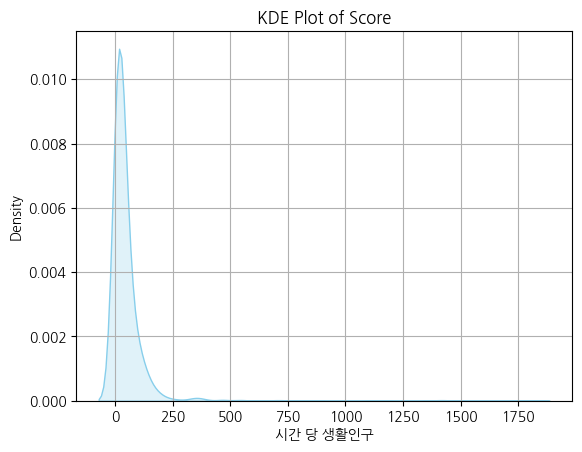

In [102]:
import seaborn as sns

sns.kdeplot(grid_gdf['집계값'].dropna(), fill=True, color='skyblue')
plt.xlabel('시간 당 생활인구')
plt.title('KDE Plot of Score')
plt.grid(True)
plt.show()


In [103]:
score_series = grid_gdf['집계값'].dropna()

ratio = (score_series <= 1).sum() / len(score_series)
print(f"1 이하인 값의 비율: {ratio:.2%}")

1 이하인 값의 비율: 0.00%


In [104]:
ratio = (score_series <= 3).sum() / len(score_series)
print(f"3 이하인 값의 비율: {ratio:.2%}")

3 이하인 값의 비율: 0.00%


In [105]:
ratio = (score_series <= 7).sum() / len(score_series)
print(f"7 이하인 값의 비율: {ratio:.2%}")

7 이하인 값의 비율: 14.04%


In [106]:
# 소수점 둘째 자리 반올림
rounded_scores = grid_gdf['집계값'].dropna().round(2)

# groupby + count
score_counts = rounded_scores.value_counts().sort_index().reset_index()
score_counts.columns = ['1시간 평균 생활인구', 'count']

print(score_counts)

      1시간 평균 생활인구  count
0            5.01      1
1            5.02      1
2            5.04      1
3            5.06      2
4            5.07      1
...           ...    ...
1032       851.95      1
1033      1145.64      1
1034      1396.08      1
1035      1439.45      1
1036      1809.71      1

[1037 rows x 2 columns]


Text(0.5, 1.0, '한글')

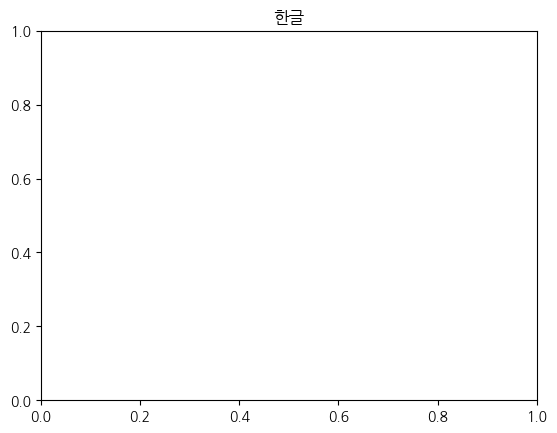

In [79]:
!pip install koreanize-matplotlib
import koreanize_matplotlib
plt.title("한글")

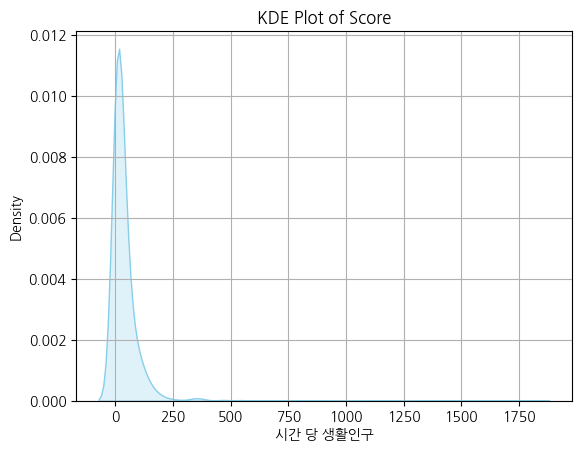

In [80]:
sns.kdeplot(score_counts['1시간 평균 생활인구'].dropna(), fill=True, color='skyblue')
plt.xlabel('시간 당 생활인구')
plt.title('KDE Plot of Score')
plt.grid(True)
plt.show()

In [88]:
grid_gdf['집계값'].sum()

np.float64(56657.8891480139)